This notebook is an experiment to create an ANN model, especially **Feed-Forward Neural Network** for predicting the closing price of EURUSD based on daily closing price


In [1]:
#Necessary Imports
import pandas as pd
import numpy as np
import yfinance as yf
import os
from datetime import date



Though I mentioned in my paper, I will use the date from https://forexsb.com/historical-forex-data. I feel using this data, will be a time comsuming  becaue eveytime, I need to donwnload it and clean for the model. And python script does not work to download. So, it is best to use **yfinance** package by yahoo finance for the time series forex data for EUR-USD. However, the forex market is closed on weekends, which means that no trading occurs from **Friday evening until Monday morning**. So, in the dataset, closing price of **Saturday and Sunday** are not included by the source provider.

In [2]:
#Download Dataset
TICKER = "EURUSD=X"
RANGE_FROM = "2015-01-01"
RANGE_TO = date.today().isoformat() #Data will be download till current day.

SAVE_DIRECTIRY = "forex_data"
FILE_NAME = "eurusd_daily.csv"

def download_data(ticker, start, end, savePath):
  print(f"Downloading Data for EUR-USD from {RANGE_FROM} to {RANGE_TO}")
  try:
    data = yf.download(ticker, start= start, end=end, progress= True)

    if data.empty:
      print(f"No data found for the {TICKER}")
    else:
      print("Successfully downloaded")
      os.makedirs(os.path.dirname(savePath), exist_ok=True)
      data.to_csv(savePath)
      print("Date saved")

  except Exception as e:
    print(f"An unexpected error: {e}")


full_save_path = os.path.join(SAVE_DIRECTIRY, FILE_NAME)
download_data(TICKER, RANGE_FROM, RANGE_TO, full_save_path)


/tmp/ipython-input-2-341652406.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start= start, end=end, progress= True)
[*********************100%***********************]  1 of 1 completed

Successfully downloaded
Date saved


In [3]:
#load csv and view from directory
if os.path.exists(full_save_path):
  forex_df = pd.read_csv(full_save_path, skiprows=3, header=None)
else:
  print("File not found")

#Cleaning Dataset. Remove every other column except Date and Close
forex_df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
forex_df.columns = forex_df.columns.str.replace(' ','')
forex_df.drop(columns=['High', 'Low', 'Open', 'Volume'], inplace=True)


print(forex_df.tail())

            Date     Close
2741  2025-07-14  1.168211
2742  2025-07-15  1.166630
2743  2025-07-16  1.160739
2744  2025-07-17  1.163575
2745  2025-07-18  1.161845


Data Preparation for Feed-Forward neural Network

In [4]:
from sklearn.preprocessing import MinMaxScaler
import joblib
closing_prices = forex_df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(closing_prices)
os.makedirs("model_scaler", exist_ok=True)
joblib.dump(scaler, "model_scaler/scaler.gz")

['model_scaler/scaler.gz']

In [5]:
SEQUENCE_LENGTH = 30
TRAIN_SPLIT = 0.7
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 1 - TRAIN_SPLIT - VALIDATION_SPLIT

X, y = [], []
for i in range(len(scaled_prices) - SEQUENCE_LENGTH):
  X.append(scaled_prices[i:i+SEQUENCE_LENGTH])
  y.append(scaled_prices[i+SEQUENCE_LENGTH])

X = np.array(X)
y = np.array(y)

print(f"Created {len(X)} seq len {SEQUENCE_LENGTH}")

train_size = int(TRAIN_SPLIT * len(X))
val_size = int(VALIDATION_SPLIT * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[-test_size:], y[-test_size:]

print(f"Train Size: {len(X_train)}")
print(f"Validation Size: {len(X_val)}")
print(f"Test Size: {len(X_test)}")

#Saving Datasets
SAVE_SETS_DIR = "prepared_sets"
os.makedirs(SAVE_SETS_DIR, exist_ok=True)
np.save(os.path.join(SAVE_SETS_DIR, "X_train.npy"), X_train)
np.save(os.path.join(SAVE_SETS_DIR, "y_train.npy"), y_train)
np.save(os.path.join(SAVE_SETS_DIR, "X_val.npy"), X_val)
np.save(os.path.join(SAVE_SETS_DIR, "y_val.npy"), y_val)
np.save(os.path.join(SAVE_SETS_DIR, "X_test.npy"), X_test)
np.save(os.path.join(SAVE_SETS_DIR, "y_test.npy"), y_test)


Created 2716 seq len 30
Train Size: 1901
Validation Size: 407
Test Size: 408


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten

#Creating Model
EPOCHS = 50
BATCH_SIZE = 32

X_train = np.load(os.path.join(SAVE_SETS_DIR, "X_train.npy"))
y_train = np.load(os.path.join(SAVE_SETS_DIR, "y_train.npy"))
X_val = np.load(os.path.join(SAVE_SETS_DIR, "X_val.npy"))
y_val = np.load(os.path.join(SAVE_SETS_DIR, "y_val.npy"))
X_test = np.load(os.path.join(SAVE_SETS_DIR, "X_test.npy"))
y_test = np.load(os.path.join(SAVE_SETS_DIR, "y_test.npy"))

MODEL = Sequential(
    [
        Input(shape=(SEQUENCE_LENGTH, 1)),
        Flatten(),  # Flatten the input to feed into Dense layers
        Dense(64, activation='sigmoid'),
        Dense(1, activation ='linear')
    ]
)

MODEL.compile(optimizer='adam', loss='mse', metrics=['mae'])
MODEL.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = MODEL.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), verbose=1)
predictions_scaled = MODEL.predict(X_test)
os.makedirs("model_scaler", exist_ok=True)
MODEL.save("model_scaler/forex_model.keras")
scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(closing_prices)
predictions_actual = scaler.inverse_transform(predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1931 - mae: 0.3336 - val_loss: 0.0203 - val_mae: 0.1275
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - mae: 0.0636 - val_loss: 0.0090 - val_mae: 0.0779
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - mae: 0.0504 - val_loss: 0.0050 - val_mae: 0.0572
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0417 - val_loss: 0.0031 - val_mae: 0.0464
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - mae: 0.0398 - val_loss: 0.0028 - val_mae: 0.0443
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - mae: 0.0364 - val_loss: 0.0028 - val_mae: 0.0430
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0356 - val_loss: 0.0026 - val_mae: 0.0420
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0348 - val_loss: 0.0026 - val_mae: 0.0409
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - mae: 

In [8]:
#calculating model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test_actual, predictions_actual)
mae = mean_absolute_error(y_test_actual, predictions_actual)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Squared Error: 0.0000
Mean Absolute Error: 0.0046
Root Mean Squared Error: 0.0062


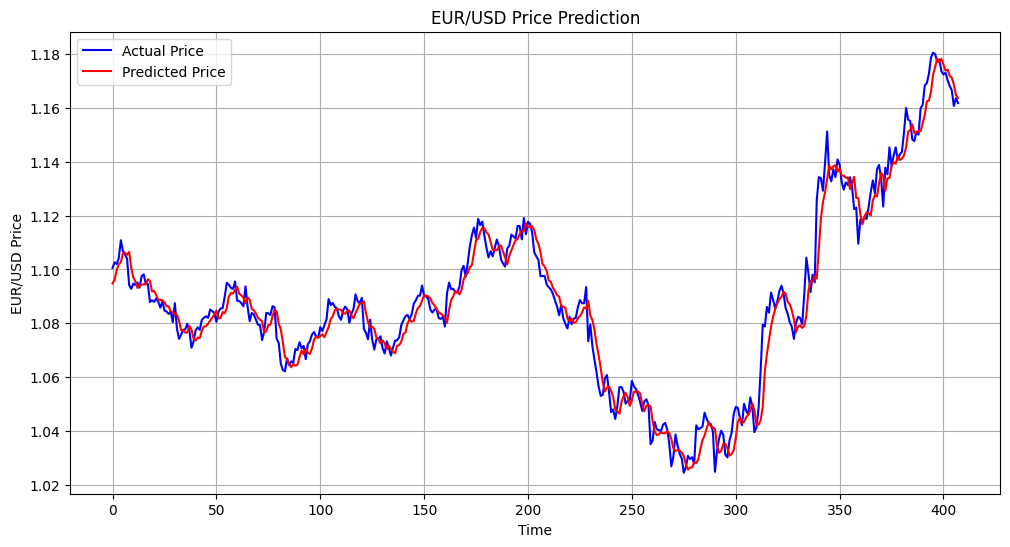

<Figure size 640x480 with 0 Axes>

In [9]:
#Generating Plot
os.makedirs("results", exist_ok=True)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(predictions_actual, label='Predicted Price', color='red')
plt.title('EUR/USD Price Prediction')
plt.xlabel('Time')
plt.ylabel('EUR/USD Price')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('results/prediction_plot.png')


Test for getting next days predicted price using latest data from the Model

